In [402]:
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

df_alimentos = pd.read_csv("alimentos.csv")

random.seed(42)

In [403]:
NUTRITIONAL_TARGETS = {
    "Energia..kcal.": 2000,
    "Proteína..g.": 75,
    "Carboidrato..g.": 275,
    "Lipídeos..g.": 70,
}

POPULATION_SIZE = 30
NUM_GENERATIONS = 1000
MUTATION_RATE = 0.5
TOURNAMENT_SIZE = 3
FOODS_PER_MEAL = 3

In [404]:
def generate_random_meal_plan(df):
    """Generate a random meal plan."""
    foods = df["Descrição dos alimentos"].dropna().unique().tolist()
    return {
        "cafe": random.sample(foods, FOODS_PER_MEAL),
        "almoco": random.sample(foods, FOODS_PER_MEAL),
        "jantar": random.sample(foods, FOODS_PER_MEAL),
    }

def calculate_nutrients(meal_plan, df):
    """Calculate total nutrients for a meal plan."""
    totals = {"Energia..kcal.": 0, "Proteína..g.": 0, "Carboidrato..g.": 0, "Lipídeos..g.": 0}
    
    for foods in meal_plan.values():
        for food in foods:
            food_data = df[df["Descrição dos alimentos"] == food]
            if not food_data.empty:
                for nutrient in totals.keys():
                    value = food_data[nutrient].values[0]
                    if pd.notna(value):
                        totals[nutrient] += value
    return totals

def calculate_fitness(meal_plan, df, targets):
    """Calculate fitness (lower deviation is better)."""
    nutrients = calculate_nutrients(meal_plan, df)
    fitness = 0
    for nutrient, target in targets.items():
        fitness -= abs(nutrients.get(nutrient, 0) - target)
    return fitness


In [405]:
def tournament_selection(population, fitnesses):
    """Select individuals using tournament selection."""
    selected = []
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), TOURNAMENT_SIZE)
        winner_idx = max(tournament_indices, key=lambda i: fitnesses[i])
        selected.append(copy.deepcopy(population[winner_idx]))
    return selected

def crossover(parent1, parent2):
    """Create offspring through crossover."""
    child = {}
    for meal in ["cafe", "almoco", "jantar"]:
        child[meal] = random.choice([parent1[meal], parent2[meal]]).copy()
    return child

def mutate_meal(meal_plan, df):
    """Mutate by replacing entire meals."""
    if random.random() < MUTATION_RATE:
        foods = df["Descrição dos alimentos"].dropna().unique().tolist()
        meal = random.choice(["cafe", "almoco", "jantar"])
        meal_plan[meal] = random.sample(foods, FOODS_PER_MEAL)
    return meal_plan

def mutate_food(meal_plan, df):
    """Mutate by replacing individual foods."""
    if random.random() < MUTATION_RATE:
        foods = df["Descrição dos alimentos"].dropna().unique().tolist()
        meal = random.choice(["cafe", "almoco", "jantar"])
        food_idx = random.randint(0, FOODS_PER_MEAL - 1)
        meal_plan[meal][food_idx] = random.choice(foods)
    return meal_plan


In [406]:
def genetic_algorithm(df, targets, initial_population=None, use_elitism=False, mutation_type="meal"):
    """Run genetic algorithm to find optimal meal plans."""
    
    # Use provided initial population or generate new one
    if initial_population is None:
        population = [generate_random_meal_plan(df) for _ in range(POPULATION_SIZE)]
    else:
        # Create deep copy to avoid modifying the original
        population = [copy.deepcopy(plan) for plan in initial_population]
    
    fitness_history = []
    
    for generation in range(NUM_GENERATIONS):
        # Calculate fitness
        fitnesses = [calculate_fitness(plan, df, targets) for plan in population]
        fitness_history.append(max(fitnesses))
        
        # Selection
        selected = tournament_selection(population, fitnesses)
        
        # Create new population
        new_population = []
        
        # Elitism: keep best individuals
        if use_elitism:
            elite_count = max(1, int(POPULATION_SIZE * 0.1))  # 10% elites
            elite_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
            for i in elite_indices[:elite_count]:
                new_population.append(copy.deepcopy(population[i]))
        
        # Generate offspring
        while len(new_population) < POPULATION_SIZE:
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            
            # Mutation
            if mutation_type == "meal":
                child1 = mutate_meal(child1, df)
                child2 = mutate_meal(child2, df)
            else:  # food
                child1 = mutate_food(child1, df)
                child2 = mutate_food(child2, df)
            
            new_population.extend([child1, child2])
        
        population = new_population[:POPULATION_SIZE]
    
    # Return best solution
    final_fitnesses = [calculate_fitness(plan, df, targets) for plan in population]
    best_idx = final_fitnesses.index(max(final_fitnesses))
    return population[best_idx], final_fitnesses[best_idx], fitness_history


In [407]:
def print_results(meal_plan, df, targets, fitness):
    """Print meal plan results as a list."""
    print("\nMelhor cardápio:")
    for meal, foods in meal_plan.items():
        print(f"- {meal}:")
        for food in foods:
            print(f"  • {food}")
    
    nutrients = calculate_nutrients(meal_plan, df)
    print("\nNutrientes:")
    for nutrient, value in nutrients.items():
        target = targets.get(nutrient, 0)
        print(f"- {nutrient}: {value:.2f} (meta: {target:.2f})")
    
    print(f"\nFitness final: {fitness:.2f}")

def plot_fitness(fitness_histories, labels):
    """Plot fitness evolution."""
    plt.figure(figsize=(15, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, (history, label) in enumerate(zip(fitness_histories, labels)):
        plt.plot(range(1, len(history) + 1), history, 
                color=colors[i % len(colors)], linewidth=2, label=label)
    
    plt.xlabel("Geração")
    plt.ylabel("Melhor Fitness")
    plt.title("Evolução do Melhor Fitness por Geração")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [408]:
# Generate shared initial population for fair comparison
print("Gerando população inicial compartilhada...")
shared_initial_population = [generate_random_meal_plan(df_alimentos) for _ in range(POPULATION_SIZE)]
print(f"População inicial gerada com {len(shared_initial_population)} indivíduos.")

# Experiment 1: Basic genetic algorithm
print("\n=== Algoritmo Genético Básico ===")
best_basic, fitness_basic, history_basic = genetic_algorithm(
    df_alimentos, NUTRITIONAL_TARGETS, 
    initial_population=shared_initial_population,
    use_elitism=False, mutation_type="meal"
)
print_results(best_basic, df_alimentos, NUTRITIONAL_TARGETS, fitness_basic)


Gerando população inicial compartilhada...
População inicial gerada com 30 indivíduos.

=== Algoritmo Genético Básico ===

Melhor cardápio:
- cafe:
  • Carne, bovina, contra-filé, com gordura, cru
  • Leite, condensado
  • Queijo, requeijão, cremoso
- almoco:
  • Achocolatado, pó
  • Brócolis, cru
  • Maniçoba
- jantar:
  • Lingüiça, frango, grelhada
  • Arroz, tipo 1, cozido
  • Glicose de milho

Nutrientes:
- Energia..kcal.: 2000.00 (meta: 2000.00)
- Proteína..g.: 77.00 (meta: 75.00)
- Carboidrato..g.: 265.50 (meta: 275.00)
- Lipídeos..g.: 72.70 (meta: 70.00)

Fitness final: -14.20


In [409]:
# Experiment 2: With elitism
print("\n=== Algoritmo Genético com Elitismo ===")
best_elitism, fitness_elitism, history_elitism = genetic_algorithm(
    df_alimentos, NUTRITIONAL_TARGETS, 
    initial_population=shared_initial_population,
    use_elitism=True, mutation_type="meal"
)
print_results(best_elitism, df_alimentos, NUTRITIONAL_TARGETS, fitness_elitism)



=== Algoritmo Genético com Elitismo ===

Melhor cardápio:
- cafe:
  • Pão, aveia, forma
  • Farinha, de mandioca, torrada
  • Chá, erva-doce, infusão 5%
- almoco:
  • Lingüiça, porco, crua
  • Refrigerante, tipo água tônica
  • Pastel, de carne, frito
- jantar:
  • Soja, extrato solúvel, natural, fluido
  • Biscoito, doce, recheado com chocolate
  • Carne, bovina, bucho, cozido

Nutrientes:
- Energia..kcal.: 1999.00 (meta: 2000.00)
- Proteína..g.: 70.20 (meta: 75.00)
- Carboidrato..g.: 275.80 (meta: 275.00)
- Lipídeos..g.: 69.40 (meta: 70.00)

Fitness final: -7.20


In [410]:
# Experiment 3: Elitism + food-level mutation
print("\n=== Algoritmo Genético com Elitismo e Mutação por Alimento ===")
best_food_mut, fitness_food_mut, history_food_mut = genetic_algorithm(
    df_alimentos, NUTRITIONAL_TARGETS, 
    initial_population=shared_initial_population,
    use_elitism=True, mutation_type="food"
)
print_results(best_food_mut, df_alimentos, NUTRITIONAL_TARGETS, fitness_food_mut)



=== Algoritmo Genético com Elitismo e Mutação por Alimento ===

Melhor cardápio:
- cafe:
  • Rabanete, cru
  • Maionese, tradicional com ovos
  • Arroz, tipo 2, cru
- almoco:
  • Beterraba, crua
  • Bacalhau, salgado, refogado
  • Estrogonofe de frango
- jantar:
  • Chocolate, meio amargo
  • Açúcar, mascavo
  • Quibe, assado

Nutrientes:
- Energia..kcal.: 2000.00 (meta: 2000.00)
- Proteína..g.: 73.00 (meta: 75.00)
- Carboidrato..g.: 274.20 (meta: 275.00)
- Lipídeos..g.: 75.30 (meta: 70.00)

Fitness final: -8.10


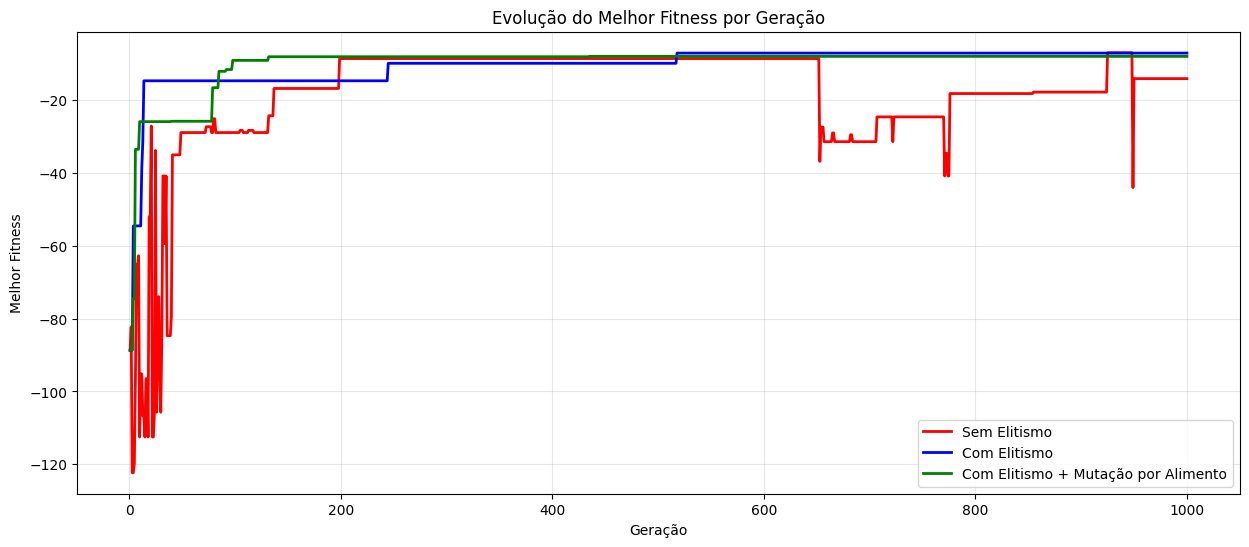

In [411]:
# Compare all approaches
plot_fitness(
    [history_basic, history_elitism, history_food_mut],
    ["Sem Elitismo", "Com Elitismo", "Com Elitismo + Mutação por Alimento"]
)


In [412]:
# Summary comparison
print("\n" + "="*60)
print("RESUMO COMPARATIVO")
print("="*60)
print("🔬 NOTA: Todos os experimentos usaram a MESMA população inicial")
print("   para garantir comparação justa entre os algoritmos!")
print("="*60)

results = [
    ("Básico", best_basic, fitness_basic),
    ("Com Elitismo", best_elitism, fitness_elitism),
    ("Elitismo + Mutação por Alimento", best_food_mut, fitness_food_mut)
]

for name, meal_plan, fitness in results:
    print(f"\n{name}: Fitness = {fitness:.2f}")
    nutrients = calculate_nutrients(meal_plan, df_alimentos)
    for nutrient, actual in nutrients.items():
        target = NUTRITIONAL_TARGETS[nutrient]
        deviation = abs(actual - target)
        accuracy = max(0, (1 - deviation / target) * 100)
        print(f"  {nutrient}: {actual:.1f}/{target:.1f} ({accuracy:.1f}%)")
    print("-" * 40)

print("\n🎯 INTERPRETAÇÃO DOS RESULTADOS:")
print("Como todos partiram do mesmo ponto, as diferenças nos")
print("resultados são puramente devidas aos algoritmos testados!")



RESUMO COMPARATIVO
🔬 NOTA: Todos os experimentos usaram a MESMA população inicial
   para garantir comparação justa entre os algoritmos!

Básico: Fitness = -14.20
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 77.0/75.0 (97.3%)
  Carboidrato..g.: 265.5/275.0 (96.5%)
  Lipídeos..g.: 72.7/70.0 (96.1%)
----------------------------------------

Com Elitismo: Fitness = -7.20
  Energia..kcal.: 1999.0/2000.0 (100.0%)
  Proteína..g.: 70.2/75.0 (93.6%)
  Carboidrato..g.: 275.8/275.0 (99.7%)
  Lipídeos..g.: 69.4/70.0 (99.1%)
----------------------------------------

Elitismo + Mutação por Alimento: Fitness = -8.10
  Energia..kcal.: 2000.0/2000.0 (100.0%)
  Proteína..g.: 73.0/75.0 (97.3%)
  Carboidrato..g.: 274.2/275.0 (99.7%)
  Lipídeos..g.: 75.3/70.0 (92.4%)
----------------------------------------

🎯 INTERPRETAÇÃO DOS RESULTADOS:
Como todos partiram do mesmo ponto, as diferenças nos
resultados são puramente devidas aos algoritmos testados!
